# Day 2 - Lectures on Structural Econometrics for Dynamic Discrete Choice Models 

# 1 - Expectation maximization algorithm. An example

The EM algorithm provides a computationally convenient way to obtain maximum likelihood estimates for "incomplete data" environments. For our purposes, we can think of settings in which each observation in the data is generated by one of two different distribution types. However, the econometrician does not observe which data point has been generated by each type, and only observes the overall distribution. The goal is to identify the distribution of each type and the distribution of the latent variable that governs the distribution over types.

In [7]:
# Load the relevant packages
using StatsKit, ForwardDiff, Ipopt, NLsolve, Optim, Parameters, Zygote, LinearAlgebra, Random, Plots, BenchmarkTools, StatsBase, Distributions

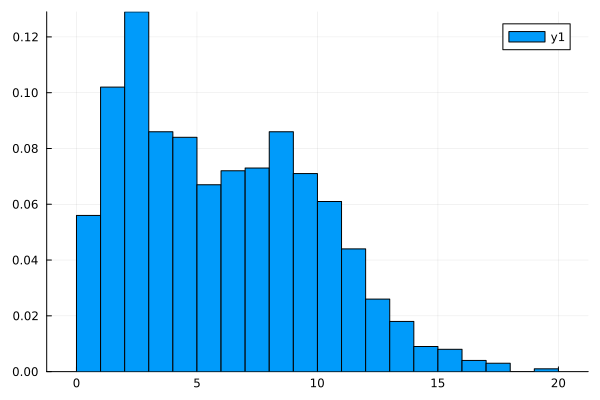

In [8]:
Random.seed!(3000);
nobs=1000;
mix_dist = MixtureModel(Poisson[Poisson(2.0), Poisson(8.0)], [0.4, 0.6]);
Y=rand(mix_dist,nobs);

ex_hist = histogram(Y,normalize=:pdf, bins=0:20)

The above figure shows the empirical distribution of 1000 observations of an integer-valued random variable . Suppose we would like to fit a parametric model to this data. The main feature of the data that complicates this exercise is that the data is bimodal with a heavy right tail, and few (if any) standard distributions for discrete random variables will accurately capture this feature. To test, this, let's try fitting a common parametric distribution such as Poisson and see how it does.

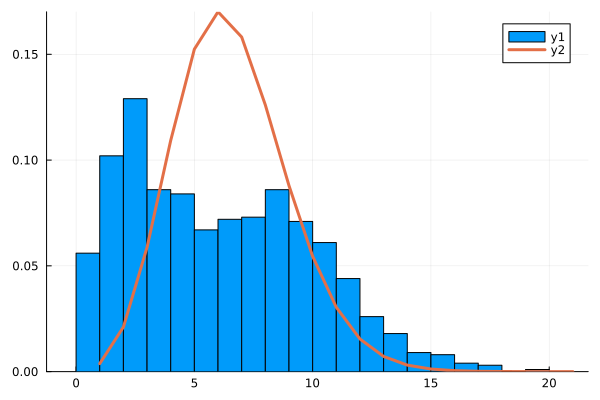

In [9]:
poisson_hat = fit_mle(Poisson, Y);
#geometric_hat = fit_mle(Geometric,Y);

histogram(Y,normalize=:pdf, bins=0:20)
plot!(pdf.(poisson_hat,0:20),linewidth=3)

As we can see from the figure above, the results are not encouraging. Simple parametric models may not suffice to accurately capture the qualitative features of the empirical distribution. While we could consider nonparametric approaches to estimating the distribution, this will have demanding data requirements. We also might have other reasons to believe that the distribution is generated by a finite number of different "types" of random draws that are mixed together in the overall distribution of $Y$.

A common way to estimate these distributions is to consider a mixture model. That is, we will assume that each draw of $Y$ is obtained from distribution $F_1$ with probability $\pi_1$ and distribution $F_2$ with probability $\pi_2 = 1 - \pi_1$. The mixing parameter $\pi_1$ governs the distribution over types, while the distributions $F_1, F_2$ describe the distribution of outcomes within each type. Typically, we will parameterize the distributions with parameters $\theta_1$ and $\theta_2$.

The log-likelihood for observation $y_i$ can be expressed as:

$$\ell_i = \log \big( \pi f_1(y_i; \theta_1) + (1-\pi) f_2(y_i;\theta_2) \big)$$

Practical applications have found that direct maximum likelihood approaches to estimating these parameters perform poorly -- convergence may be slow, there can be many local optima, and the estimates may be extremely sensitive to starting values for the parameters. The alternative approach of Dempster et al (1977) is to update the parameters $\pi$ and $(\theta_1, \theta_2)$ in separate stages. The main features of the estimator can be described in four steps:

- Fix initial values for $\theta_1^{(0)}, \theta_2^{(0)}$, and $\pi^{(0)}$ and set convergence criteria.
- Given the current values for $\theta_1^{(0)}, \theta_2^{(0)}$, compute the probability of each observation type. This yields an updated value for $\pi_1$.
- Hold fixed the type probabilty computed in step 2 and maximize the likelihood with respect to $\theta_1, \theta_2$. This yields updated values for $\theta_1, \theta_2$.
- Repeat steps 2-3 until convergence (per-iteration change in the overall likelihood is "small").

We will implement this algorithm on the data set above using the assumptions that (i) there are two components in the mixture (i.e., observations are each associated with one of two unobserved types) and (ii) the two types $j \in \{1,2\}$ follow a Poisson distribution with parameter $\theta_j$.

In [31]:
# Step 1 (a): initial values for theta and lambda
theta_0=[1.0,3.0];
pi_0=[0.5,0.5];

# Step 1 (b): specify convergence criteria
iter=1;
maxiter=1000;
lik0=10.0;
normdiff=10.0;
tolerance=1e-6;


In [35]:
    while normdiff>tolerance && iter<=maxiter
        EZ = [(pi_0[j]*pdf(Poisson(theta_0[j]),Y[i]))/(sum(pi_0[k]*pdf(Poisson(theta_0[k]),Y[i]) for k∈eachindex(pi_0))) for i ∈ eachindex(Y), j ∈ eachindex(pi_0)];
        theta_fun(theta_0) = -sum(EZ[i,j]*log(pdf(Poisson(theta_0[j]),Y[i])) for i ∈ eachindex(Y), j ∈ eachindex(pi_0))
        pi_0=mean(EZ,dims=1);
        b=optimize(theta_fun,theta_0);
        # Calculate likelihood and update for next iteration:
        theta_0=b.minimizer;
        lik1 = -theta_fun(theta_0) + sum(log(pi_0[j])*EZ[i,j] for i∈eachindex(Y), j∈eachindex(pi_0));
        likdiff=abs(lik1-lik0);
        lik0=lik1;
        iter=iter+1;
    end

println(string("π_1, π_2 estimated to:",round.(pi_0,digits=3)))
println(string("θ_1, θ_2 estimated to:",round.(theta_0,digits=3)))


π_1, π_2 estimated to:[0.432 0.568]
θ_1, θ_2 estimated to:[2.138, 8.198]


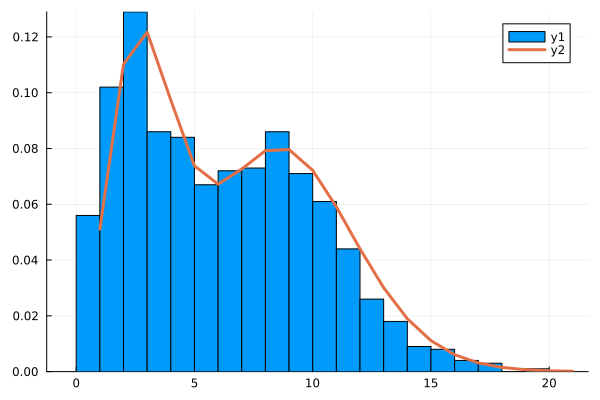

In [40]:
histogram(Y,normalize=:pdf, bins=0:20)
plot!(pdf.(Poisson(theta_0[1]),0:20)*pi_0[1] .+ pdf.(Poisson(theta_0[2]),0:20)*pi_0[2],linewidth=3)

# 2 - Bus engine model with unobserved types (s)

Now we apply the EM algorithm to a dynamic discrete choice model. The basic features of the algorithm do not change: at each iteration, we compute the probability of each individual (or bus) of being of type $s$ given the most recent estimates for $\mathbf{\theta}$, and then use these probabilities to obtain a new estimate for $\mathbf{\theta}$. 

In [42]:
# Data generation (same as yesterday's)

x_min=0.0;
x_max=15.0;
x_int=0.05;
x_len=Int64(1+(x_max-x_min)/x_int);
X=range(x_min,x_max,x_len);

F1=zeros(x_len,x_len);
F1[:,1].=1.0;

x_tday      = repeat(X, 1, x_len); 
x_next      = x_tday';
x_zero      = zeros((x_len, x_len));

F2 = (x_next.>=x_tday) .* exp.(-(x_next - x_tday)) .* (1 .- exp(-x_int));
F2[:,end]=1 .-sum(F2[:,1:(end-1)],dims=2);
F2_cumul=cumsum(F2,dims=2);

S=[1, 2];
s_len=Int64(length(S));

"""
This function pefrorms value iteration, which is needed to solve the model.
"""
function value_function_iteration(x::AbstractRange{Float64},S::Vector{Int64},F1::Matrix{Float64},F2::Matrix{Float64},β::Number,θ::Vector;MaxIter=1000)
    x_len=length(x);
    γ=Base.MathConstants.eulergamma;
    value_function2=zeros(x_len,length(S));
    value_diff=1.0;
    tol=1e-5;
    iter=1;
    local v1, v2
    while (value_diff>tol) && (iter<=MaxIter)
        value_function1=value_function2;
        v1=[0.0 + β*F1[j,:]'*value_function1[:,s] for j∈eachindex(X), s∈eachindex(S)];
        v2=[θ[1]+θ[2]*X[j]+θ[3]*S[s] + β*(F2[j,:]'*value_function1[:,s]) for j=1:x_len, s∈eachindex(S)];
        value_function2=[log(exp(v1[j,s])+exp(v2[j,s]))+γ for j=1:x_len, s=1:length(S)];
        iter=iter+1;
        value_diff=maximum((value_function1 .- value_function2).^2);
    end
    ccps=[1/(1+exp(v2[j,s,]-v1[j,s])) for j=1:x_len, s=1:length(S)];
    return (ccps_true=ccps, value_function=value_function2)
end

"""
This function generates data. 
"""
function generate_data(N,T,X,S,F1,F2,F_cumul,β,θ;T_init=10,π=0.4,ex_initial=0)
    if ex_initial==1
        T_init=0;
    end
    x_data=zeros(N,T+T_init);
    x_data_index=Array{Int32}(ones(N,T+T_init));
    if ex_initial==1
        x_data_index[:,1]=rand(1:length(X),N,1);
        x_data[:,1]=X[x_data_index[:,1]];
    end
    s_data=(rand(N) .> π) .+ 1;
    d_data=zeros(N,T+T_init);

    draw_ccp=rand(N,T+T_init);
    draw_x=rand(N,T+T_init);

    (ccps,_)=value_function_iteration(X,S,F1,F2,β,θ);

    for n=1:N
        for t=1:T+T_init
            d_data[n,t]=(draw_ccp[n,t] > ccps[x_data_index[n,t],s_data[n]])+1;
            if t<T+T_init
                x_data_index[n,t+1]=1 + (d_data[n,t]==2)*sum(draw_x[n,t] .> F_cumul[x_data_index[n,t],:]); 
                x_data[n,t+1]=X[x_data_index[n,t+1]];
            end
        end
    end

    return (XData=x_data[:,T_init+1:T+T_init], SData=repeat(s_data,1,T),
        DData=d_data[:,T_init+1:T+T_init],
        XIndexData=x_data_index[:,T_init+1:T_init+T],
        TData=repeat(1:T,N,1),
        NData=repeat((1:N)',1,T)) 
end

# Set the number of buses, time periods and value of parameters
N=2000;
T=15;
θ=[2.0, -0.15, 1.0];
β=0.9;
π=0.4;

Random.seed!(3000);
XData, SData, DData, XIndexData, TData, NData = generate_data(N,T,X,S,F1,F2,F2_cumul,β,θ);